### *Information Theory and Inference*

# **Auto-Encoding Variational Bayes**

# **Library Loading**

In [23]:
### Torch libraries
import torch
import torch.nn as nn
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torch.nn.functional as F
import torchaudio
from torch.utils.data import TensorDataset


### Libraries for plotting
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Others
import random
import pathlib
import tensorflow as tf
from torch.utils.data import TensorDataset
from sklearn.manifold import TSNE
from IPython import display
from tqdm import tqdm

### Our functions
from vae_functions import*

# Set seed for reproducibility
random.seed(111)

**Clean GPU memory**

In [2]:
torch.cuda.empty_cache()

**Enable GPU for fast processing**

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# **1. Datasets Loading**

## **1.1 MNIST**

### **1.1.1 Data loading**

In [5]:
# INIIILIZATION
path = '~/datasets'
batch_size = 64

# Create a transofrm to apply to each datapoint
transform = transforms.Compose([transforms.ToTensor()])

# Download dataset
MNIST_traindataset_raw = MNIST(path, transform=transform, download=True)
MNIST_testdataset_raw = MNIST(path, transform=transform, download=True)

# Create train and test set
MNIST_traindataset = DataLoader(dataset=MNIST_traindataset_raw, batch_size=batch_size, shuffle=True)
MNIST_testdataset = DataLoader(dataset=MNIST_testdataset_raw, batch_size=batch_size, shuffle=False)

### **1.1.2 Data plotting**

'Images generated successfully!'

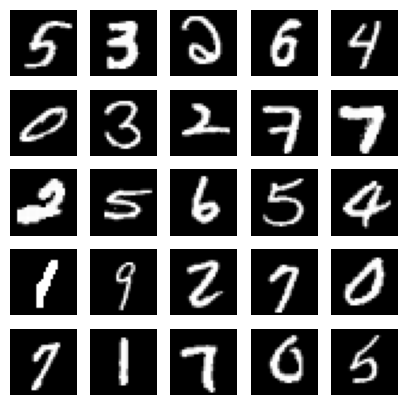

In [6]:
# Plot samples
data_plotting(MNIST_traindataset, 25)

# **2. Model creation**

## **2.1 Variational Auto-Encoder with flatten data**

For the first model, we create a simple vanilla model for the VAE. The structure is as follows:

1. Hidden Layer for imaging processing
2. Distinguished latent layer for the mu and the sigma value.
3. Reparametrization trick where the output is transformed using a gaussian distribution.
4. Latent layer for converting into hidden layer size
5. Hidden Layer for imaging conversion

In [7]:
class VAE_vanilla(nn.Module):
    """
    VARIATIONAL AUTO-ENCODER

    Structure:
        Encoding: Imp Layer -> Hidden Layer -> Latent Layer ->  Final Layer (mu)       
                                                                Final Layer (logvar)

        Gaussian Reparametrization: Mu       ->  Z
                                    Logvar
    
        Decoding: Z -> Final Layer -> Latent Layer -> Hidden Layer -> Imp Layer (Sigmoid)

    """

    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=40, final_dim = 20, relu_factor = 0.2,  device=device):
        super(VAE_vanilla, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(relu_factor),
            nn.Linear(hidden_dim, latent_dim),
            nn.LeakyReLU(relu_factor)
            )
        
        # Mean and Logvar
        self.mean_layer = nn.Linear(latent_dim, final_dim)
        self.logvar_layer = nn.Linear(latent_dim, final_dim)
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(final_dim, latent_dim),
            nn.LeakyReLU(relu_factor),
            nn.Linear(latent_dim, hidden_dim),
            nn.LeakyReLU(relu_factor),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
            )
     
    def encode(self, x):
        """
        Encode image 
        """
        x = self.encoder(x)
        mean, logvar = self.mean_layer(x), self.logvar_layer(x)
        return mean, logvar

    def reparameterization_gaussian(self, mean, var):
        """
        Perform reparametrization trick using a gaussian function
        """
        epsilon = torch.randn_like(var).to(device)      
        z = mean + var*epsilon
        return z

    def decode(self, x):
        """
        Decode image 
        """
        return self.decoder(x)

    def forward(self, x):
        """
        Perform forward propagation of image
        """
        mean, logvar = self.encode(x)
        z = self.reparameterization_gaussian(mean, logvar)
        x_hat = self.decode(z)
        return x_hat, mean, logvar

**Loss function**

In [8]:
def loss_function(x, x_hat, mean, log_var, size = None, beta= 1):

    if size!= None:
        x_hat = scale_data(x_hat, size = size, resize= True)
        
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD = -0.5*beta * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD

### **2.1.1 MNIST with Z=2**

**Compile model**

In [9]:
######## INITIAL PARAMETERS LOADING

# Get image size
for img, lbl in MNIST_traindataset:
    break

# AUTO-ENCODER PARAMETERS
INP_DIM = img[0].squeeze().shape[0]*img[0].squeeze().shape[1]
HID_DIM = 400
LAT_DIM = 40
FIN_DIM = 2
RELU_T = 0.2

# TRAINING PARAMETERS
model_vmnist = VAE_vanilla(INP_DIM, HID_DIM, LAT_DIM, FIN_DIM,RELU_T ).to(device)
optimizer = torch.optim.Adam(model_vmnist.parameters(), lr=1e-3)
epochs = 50

**Model training**

In [11]:
def train_model(model, dataset, epochs, batch_size, 
                optimizer, device, input_dim = 784,
                model_type = "Linear", verbose = 0, size = None, beta= 1):
    """
    Train a Variational Auto-Encoder from scratch using PyTorch

    Args: 
        model -> VAE model -> class
        dataset -> training set to be used -> tensor
        epochs -> number of epochs for training -> int
        batch_size -> batch sizes of training dataset -> int
        optimizer -> model optimizer 
        input_dim -> flatten dimension to the desire value -> int
        verbose -> show loss at each epoch -> [0,1]
    
    Return:
        overall_loss -> loss 
        model -> trained model

    """

    # Initialize model 
    model.train()
    print("Starting model training...")

    total_loss =[]
    # Star iteration 
    for epoch in range(epochs):
        
        # Reset loss
        overall_loss = 0
        # Start iteration in batches
        for batch_idx, (x, _) in tqdm(enumerate(dataset)):

            # Flatten image if needed
            if model_type == "Linear":
                x = x.view(len(x),input_dim )
            elif model_type == "Audio":
                a, b, c = x.shape
                x = scale_data(x).view(1, a, b, c)
    

            # Run model 
            optimizer.zero_grad()  # Set gradients to zero for avoiding gradient propagation
            x_hat, mean, log_var = model(x.to(device))  # Generate images alongside with parameters from reparametrization trick
            loss = loss_function(x.to(device), x_hat, mean, log_var, size, beta) # Compute loss
            
            # Extraxt loss and sum
            overall_loss += loss.item()
            
            # Backpropagate model 
            loss.backward()
            optimizer.step()
        
        # Display training metrics at each epoch
        total_loss.append(overall_loss/(batch_idx*batch_size))
        if verbose == 1: 
            print("\tEpoch", epoch + 1, "\tAverage Loss: ", overall_loss/(batch_idx*batch_size))
    
    print("Model training successfully")
        
    return total_loss, model

In [11]:
# Run model for MNIST dataset
loss_mnist_v, model_mnist_v = train_model(model_vmnist, MNIST_traindataset, epochs,
                                           batch_size, optimizer, device, INP_DIM,
                                           "Linear", verbose = 0)

Starting model training...


938it [00:20, 45.28it/s]
938it [00:22, 41.14it/s]
938it [00:23, 40.45it/s]
938it [00:23, 39.70it/s]
938it [00:22, 40.90it/s]
938it [00:23, 40.70it/s]
938it [00:23, 40.54it/s]
938it [00:23, 39.65it/s]
938it [00:24, 38.80it/s]
938it [00:23, 40.67it/s]
938it [00:24, 38.34it/s]
938it [00:24, 38.94it/s]
938it [00:22, 41.19it/s]
938it [00:23, 39.27it/s]
938it [00:22, 40.92it/s]
938it [00:22, 40.91it/s]
938it [00:23, 39.38it/s]
938it [00:22, 41.10it/s]
938it [00:24, 38.10it/s]
938it [00:22, 40.92it/s]
938it [00:22, 41.25it/s]
938it [00:23, 39.20it/s]
938it [00:22, 41.53it/s]
938it [00:23, 40.25it/s]
938it [00:23, 39.60it/s]
938it [00:23, 40.54it/s]
938it [00:24, 38.57it/s]
938it [00:22, 40.92it/s]
938it [00:23, 40.33it/s]
938it [00:23, 39.20it/s]
938it [00:22, 41.37it/s]
938it [00:23, 39.82it/s]
938it [00:22, 41.15it/s]
938it [00:22, 41.01it/s]
938it [00:24, 38.86it/s]
938it [00:22, 41.01it/s]
938it [00:25, 36.78it/s]
938it [00:27, 34.60it/s]
938it [00:25, 37.24it/s]
938it [00:25, 36.10it/s]


Model training successfully


'Loss plotted successfully'

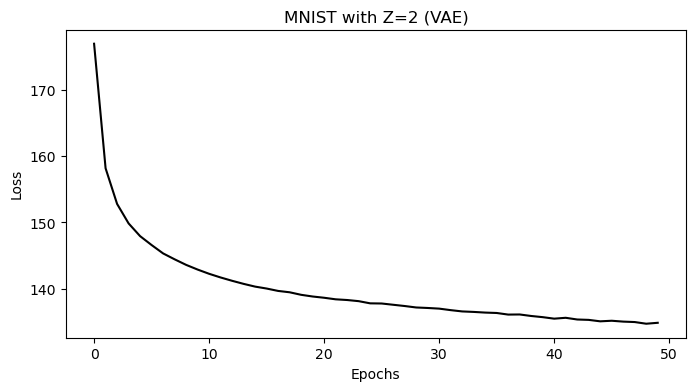

In [12]:
# Display loss
plot_loss(loss_mnist_v, "MNIST with Z=2 (VAE)")

**Samples generation**

In [13]:
# Extract samples from the dataset (one for each number)
samples_mnist_1, _ = mnist_extractor(1, MNIST_testdataset_raw)

# Encode random images
encoded_nmist_v = encoding_VAE(samples_mnist_1, model_mnist_v, device )

# Decode random images
decoded_mnist_v, z_mnist_v = decoding_VAE(encoded_nmist_v, model_mnist_v, device)

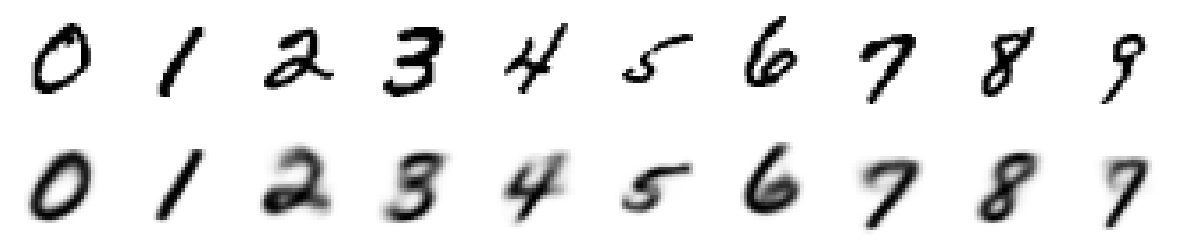

In [14]:
# Show comparison

fig, axis = plt.subplots(2,10, figsize= (15,3))
for i in range(len(samples_mnist_1)):
    axis[0][i].imshow(samples_mnist_1[i].view(28,28), cmap = "gray_r")
    axis[1][i].imshow(decoded_mnist_v[i], cmap ="gray_r")
    axis[0][i].axis("off")
    axis[1][i].axis("off")

**Distribution map**

In [15]:
# Take 100 samples for each label in the mnist dataset and perform VAE
samples_mnist_100, label_mnist_100 = mnist_extractor(100, MNIST_testdataset_raw)
encoded_nmist_v_100 = encoding_VAE(samples_mnist_100, model_mnist_v, device )
decoded_mnist_v_100, z_mnist_v_100 = decoding_VAE(encoded_nmist_v_100, model_mnist_v, device)

(Text(0.5, 0, 'Z1'),
 Text(0, 0.5, 'Z2'),
 Text(0.5, 1.0, 'Distribution MNIST for Z=2'))

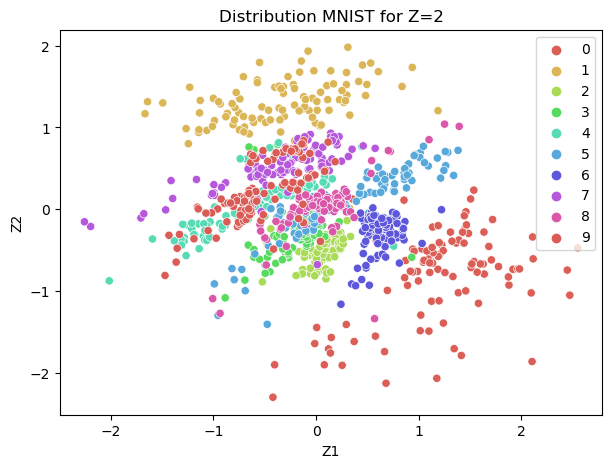

In [16]:
# Create plot
fig, axis = plt.subplots(1,1, figsize =(7,5))

# Show label distribution
axis = sns.scatterplot(x= z_mnist_v_100[:,0],y= z_mnist_v_100[:,1], hue = label_mnist_100, legend = "full", palette="hls")
axis.set_xlabel("Z1"), axis.set_ylabel("Z2"), axis.set_title("Distribution MNIST for Z=2")

**Manifold**

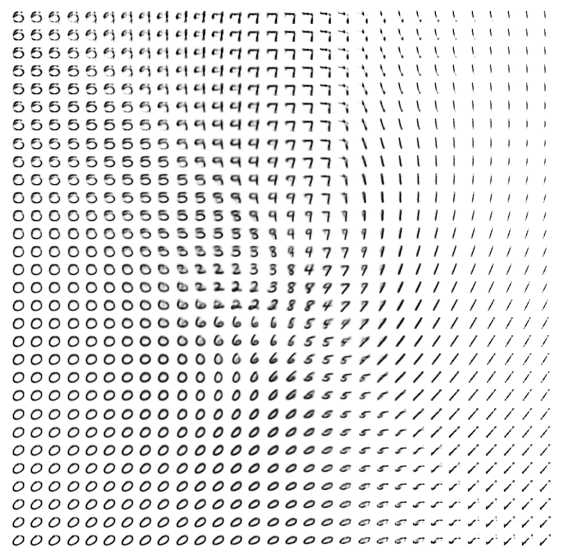

In [17]:
# Create random Z variables for recreate images using VAE
array = np.arange(-3,3, 0.2)
z_val = []
for i in range(len(array)):
    for j in range(len(array)):
        z_val.append(torch.tensor([[array[i],array[j]]], dtype = torch.float32).to(device))

fig, axis = plt.subplots(30, 30, figsize = (7,7))
axis = axis.flatten()

for i in range(30*30):
    axis[i].imshow(model_mnist_v.decode(z_val[i]).reshape(28,28).to("cpu").detach().numpy(), cmap="gray_r"), axis[i].axis("off")

### **2.1.2 MNIST with Z=20**

**Compile model**

In [18]:
######## INITIAL PARAMETERS LOADING

# Get image size
for img, lbl in MNIST_traindataset:
    break

# AUTO-ENCODER PARAMETERS
INP_DIM = img[0].squeeze().shape[0]*img[0].squeeze().shape[1]
HID_DIM = 400
LAT_DIM = 40
FIN_DIM = 20 #40 # z
RELU_T = 0.2

# TRAINING PARAMETERS
model_vmnist_f = VAE_vanilla(INP_DIM, HID_DIM, LAT_DIM, FIN_DIM,RELU_T ).to(device)
optimizer = torch.optim.Adam(model_vmnist_f.parameters(), lr=1e-3)
epochs = 50

**Model training**

In [19]:
# Run model for MNIST dataset
loss_mnist_vf, model_mnist_vf = train_model(model_vmnist_f, MNIST_traindataset, epochs,
                                           batch_size, optimizer, device, INP_DIM,
                                           "Linear", verbose = 0)

Starting model training...


938it [00:20, 45.98it/s]
938it [00:23, 39.18it/s]
938it [00:23, 39.88it/s]
938it [00:23, 40.51it/s]
938it [00:25, 37.04it/s]
938it [00:44, 21.13it/s]
938it [00:28, 32.94it/s]
938it [00:29, 31.79it/s]
938it [00:29, 31.63it/s]
938it [00:45, 20.50it/s]
938it [00:49, 19.01it/s]
938it [00:48, 19.15it/s]
938it [00:49, 18.92it/s]
938it [00:49, 18.87it/s]
938it [00:51, 18.32it/s]
938it [00:49, 18.82it/s]
938it [00:49, 18.99it/s]
938it [00:49, 18.80it/s]
938it [00:49, 18.84it/s]
938it [00:49, 18.94it/s]
938it [00:49, 18.85it/s]
938it [00:49, 18.89it/s]
938it [00:49, 18.97it/s]
938it [00:49, 18.77it/s]
938it [00:50, 18.75it/s]
938it [00:50, 18.74it/s]
938it [00:49, 18.85it/s]
938it [00:49, 18.95it/s]
938it [00:32, 29.10it/s]
938it [00:17, 53.02it/s]
938it [00:17, 53.13it/s]
938it [00:17, 52.14it/s]
938it [00:17, 52.37it/s]
938it [00:13, 68.40it/s]
938it [00:12, 73.74it/s]
938it [00:17, 54.48it/s]
938it [00:17, 53.52it/s]
938it [00:18, 51.99it/s]
938it [00:17, 53.90it/s]
938it [00:17, 53.68it/s]


Model training successfully


'Loss plotted successfully'

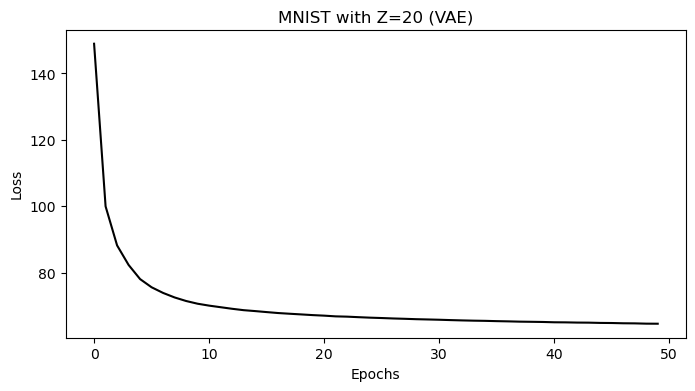

In [20]:
# Display loss
plot_loss(loss_mnist_vf, "MNIST with Z={} (VAE)".format(FIN_DIM))

**Samples generation**

In [21]:
# Extract samples from the dataset (one for each number)
samples_mnist_1, _ = mnist_extractor(1, MNIST_testdataset_raw)

# Encode random images
encoded_nmist_vf = encoding_VAE(samples_mnist_1, model_mnist_vf, device )

# Decode random images
decoded_mnist_vf, z_mnist_vf = decoding_VAE(encoded_nmist_vf, model_mnist_vf, device)

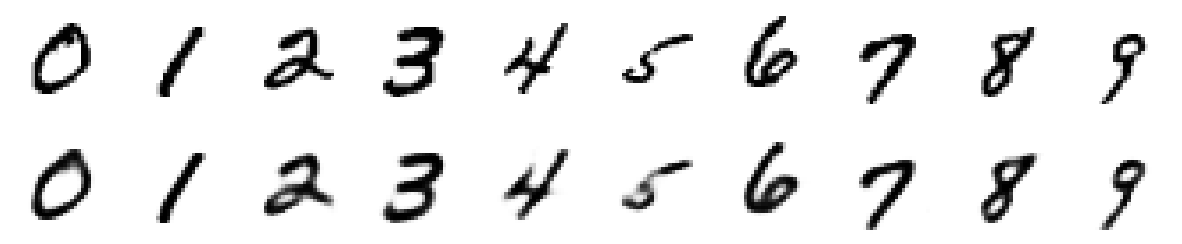

In [22]:
# Show comparison
fig, axis = plt.subplots(2,10, figsize= (15,3))
for i in range(len(samples_mnist_1)):
    axis[0][i].imshow(samples_mnist_1[i].view(28,28), cmap = "gray_r")
    axis[1][i].imshow(decoded_mnist_vf[i], cmap ="gray_r")
    axis[0][i].axis("off")
    axis[1][i].axis("off")

**Distribution map**

In [23]:
# Take 1000 samples for each label in the mnist dataset and perform VAE
samples_mnist_1000, label_mnist_1000 = mnist_extractor(100, MNIST_testdataset_raw, type = "Linear")

# Encode random images
encoded_nmist_vf = encoding_VAE(samples_mnist_1000, model_mnist_vf, device )

# Decode random images
decoded_mnist_vf, z_mnist_vf = decoding_VAE(encoded_nmist_vf, model_mnist_vf, device)

# Apply TSNE for show distribution map
z_embedeed_vf_1000 = TSNE(n_components=2, learning_rate='auto', init='random',method ="exact", perplexity=3).fit_transform(z_mnist_vf)

Text(0.5, 1.0, 'TSNE for MNIST using VAE Z = 20')

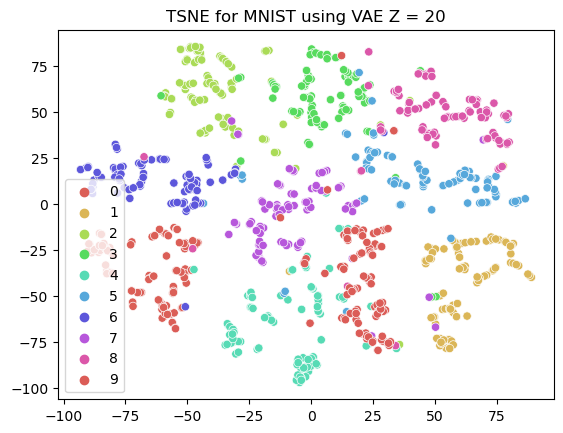

In [24]:
axis = sns.scatterplot(x= z_embedeed_vf_1000[:,0],y= z_embedeed_vf_1000[:,1], hue = label_mnist_1000, legend = "full", palette="hls")
axis.set_title("TSNE for MNIST using VAE Z = {}".format(FIN_DIM))

### **2.1.3 Comparison with higher dimensions**

**Load and Run several models**

In [33]:
def model_comparator(dimension_variables, epochs, dataset, device, VAEmodel, batch_size, INP_DIM, HID_DIM, LAT_DIM, RELU_T, train_model):
    """
    Perform training with different latent dimension sizes.

    Args:
        dimension_variables -> size of the latent dimension -> list
        epochs -> number of epochs for training model
        dataset -> dataset to be used
    
    Return:
        trained_models -> trained models with different latent dimension size.
    """
    # Initialize parameters
    #INP_DIM = 784
    #HID_DIM = 400
    #LAT_DIM = 40
    trained_models = []
    #batch_size = 64
    print("Starting training...")
    # Iterate for each dimension size
    for i in range(len(dimension_variables)):
        model_vmnist = VAEmodel(INP_DIM, HID_DIM, LAT_DIM, dimension_variables[i], RELU_T ).to(device)
        optimizer = torch.optim.Adam(model_vmnist.parameters(), lr=1e-3)
        loss, model = train_model(model_vmnist, dataset, 
                                  epochs, batch_size, optimizer, device, INP_DIM)
        trained_models.append((loss, model))

        print("Comb {} with final dimension {} finished successfully! ".format(i, dimension_variables[i]))
    
    return trained_models

In [37]:
# Train model for 5 different final dimensions
dim_values = [5, 10, 15, 20, 25]
epochs = 5 #50
mnist_models_v = model_comparator(dim_values, epochs, MNIST_traindataset, device, VAE_vanilla, batch_size, INP_DIM, HID_DIM, LAT_DIM, RELU_T, train_model)

Starting training...
Starting model training...


938it [00:12, 77.43it/s]
938it [00:12, 76.36it/s]
938it [00:12, 76.19it/s]
938it [00:12, 75.88it/s]
938it [00:12, 74.84it/s]


Model training successfully
Comb 0 with final dimension 5 finished successfully! 
Starting model training...


938it [00:12, 74.68it/s]
938it [00:12, 72.50it/s]
938it [00:12, 74.40it/s]
938it [00:12, 73.26it/s]
938it [00:12, 72.46it/s]


Model training successfully
Comb 1 with final dimension 10 finished successfully! 
Starting model training...


938it [00:13, 71.74it/s]
938it [00:12, 72.51it/s]
938it [00:12, 72.43it/s]
938it [00:12, 72.19it/s]
938it [00:13, 72.15it/s]


Model training successfully
Comb 2 with final dimension 15 finished successfully! 
Starting model training...


938it [00:13, 70.68it/s]
938it [00:12, 73.03it/s]
938it [00:12, 72.30it/s]
938it [00:13, 69.34it/s]
938it [00:15, 58.82it/s]


Model training successfully
Comb 3 with final dimension 20 finished successfully! 
Starting model training...


938it [00:13, 70.92it/s]
938it [00:14, 66.67it/s]
938it [00:13, 69.61it/s]
938it [00:13, 70.89it/s]
938it [00:13, 70.73it/s]

Model training successfully
Comb 4 with final dimension 25 finished successfully! 


**Generate samples**

In [44]:
# Generate images
mnist_images_v = samples_comparator(samples_mnist_1, mnist_models_v, device)

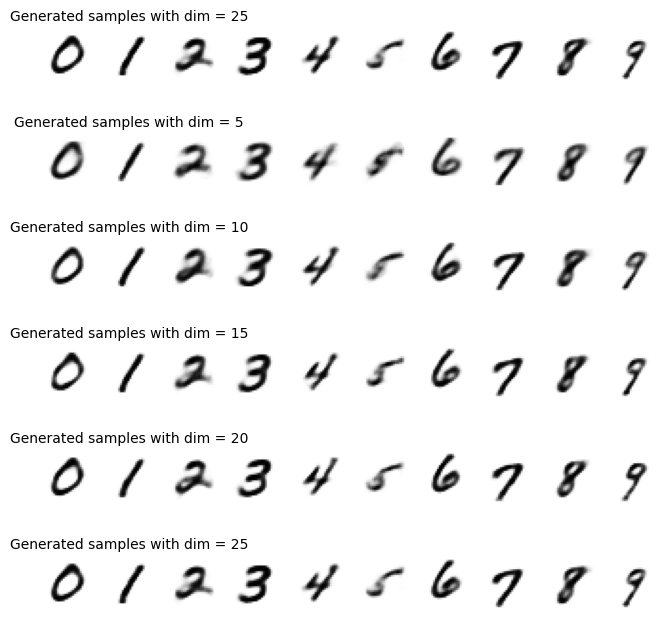

In [45]:
# Plot comparison of generated images with different final dimensions
fig, axis = plt.subplots(len(mnist_models_v) +1, 10, figsize=(8,8))

for i in range(len(mnist_models_v)+1):
    for j in range(10):
        if i==0:
            axis[i][j].imshow(samples_mnist_1[j].view(28,28), cmap = "gray_r"), axis[i][j].axis("off")
            if i == 0 and j == 1:
                axis[i][j].set_title("Original samples", fontsize = 10)
            
        if j == 1:
            axis[i][j].set_title("Generated samples with dim = {}".format(dim_values[i-1]), fontsize = 10)

            
            
        axis[i][j].imshow(mnist_images_v[i-1][j], cmap = "gray_r"), axis[i][j].axis("off")


In [46]:
# loss - [5,10,15,20,25]
loss_list_plot_mnist = [mnist_models_v[i][0] for i in range(len(mnist_models_v))]

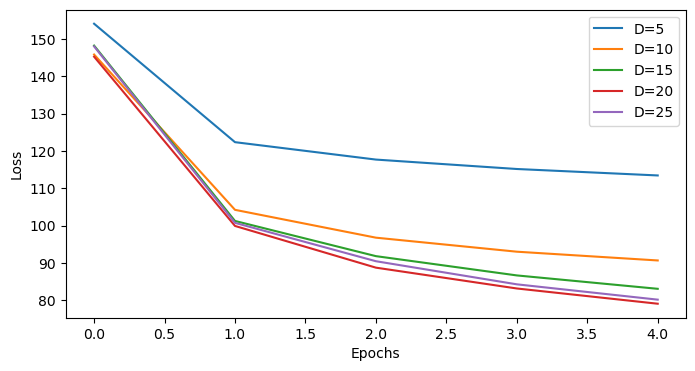

In [47]:
def plot_loss(dim_values,loss_list):
    """
    Display loss evolution for multiple dimension values

    Args: 
        loss_list: List of tuples containing dimension value and corresponding loss values per epoch
    """

    # Create and display plot
    fig, axis = plt.subplots(1, 1, figsize=(8, 4))

    for dim, loss in zip(dim_values,loss_list):
        axis.plot(loss, label=f'D={dim}')

    axis.set_xlabel("Epochs")
    axis.set_ylabel("Loss")
    axis.legend()
    plt.show()


plot_loss(dim_values, loss_list_plot_mnist)

### **2.1.4 B-factor**

In [9]:
######## INITIAL PARAMETERS LOADING

# Get image size
for img, lbl in MNIST_traindataset:
    break

# AUTO-ENCODER PARAMETERS
INP_DIM = img[0].squeeze().shape[0]*img[0].squeeze().shape[1]
HID_DIM = 400
LAT_DIM = 40
FIN_DIM = 2 # z
RELU_T = 0.2

# TRAINING PARAMETERS
model_vmnist_f = VAE_vanilla(INP_DIM, HID_DIM, LAT_DIM, FIN_DIM,RELU_T ).to(device)
optimizer = torch.optim.Adam(model_vmnist_f.parameters(), lr=1e-3)
epochs = 25

In [14]:
# Run model for MNIST dataset 
# CHANGE BETA VALUES
z_embedeed_vf_1000_beta = []
label_mnist_1000_beta = []
loss_mnist_v_list_plot_mnist = []
betas = [0.25, 1, 5, 10, 15, 20] #[1, 5, 10, 15, 20, 25, -5, -10]#, -15]
for beta_i in betas:

    loss_mnist_v, model_mnist_v = train_model(model_vmnist_f, MNIST_traindataset, epochs,
                                            batch_size, optimizer, device, INP_DIM,
                                            "Linear", verbose = 0, beta=beta_i)
    
    # Take 1000 samples for each label in the mnist dataset and perform VAE
    samples_mnist_1000, label_mnist_1000 = mnist_extractor(100, MNIST_testdataset_raw, type = "Linear")

    # Encode random images
    encoded_nmist_vf = encoding_VAE(samples_mnist_1000, model_vmnist_f, device )

    # Decode random images
    decoded_mnist_vf, z_mnist_vf = decoding_VAE(encoded_nmist_vf, model_vmnist_f, device)

    # Apply TSNE for show distribution map
    z_embedeed_vf_1000 = TSNE(n_components=2, learning_rate='auto', init='random',method ="exact", perplexity=3).fit_transform(z_mnist_vf)

    # Store in lists
    z_embedeed_vf_1000_beta.append(z_embedeed_vf_1000)
    label_mnist_1000_beta.append(label_mnist_1000)
    loss_mnist_v_list_plot_mnist.append(loss_mnist_v)

Starting model training...


938it [00:12, 74.63it/s]
938it [00:13, 69.57it/s]
938it [00:12, 73.07it/s]
938it [00:13, 71.67it/s]
938it [00:13, 71.41it/s]
938it [00:13, 71.99it/s]
938it [00:13, 71.83it/s]
938it [00:13, 70.97it/s]
938it [00:13, 71.44it/s]
938it [00:13, 71.20it/s]
938it [00:13, 71.21it/s]
938it [00:13, 68.91it/s]
938it [00:13, 71.13it/s]
938it [00:12, 76.45it/s]
938it [00:13, 71.11it/s]
938it [00:13, 69.59it/s]
938it [00:12, 72.38it/s]
938it [00:13, 71.53it/s]
938it [00:13, 71.81it/s]
938it [00:13, 71.72it/s]
938it [00:13, 71.06it/s]
938it [00:13, 70.27it/s]
938it [00:12, 73.12it/s]
938it [00:14, 67.00it/s]
938it [00:18, 50.34it/s]


Model training successfully
Starting model training...


938it [00:12, 77.74it/s]
938it [00:12, 72.25it/s]
938it [00:13, 70.84it/s]
938it [00:12, 74.89it/s]
938it [00:12, 74.27it/s]
938it [00:12, 72.27it/s]
938it [00:13, 71.59it/s]
938it [00:13, 69.47it/s]
938it [00:13, 70.29it/s]
938it [00:13, 71.10it/s]
938it [00:13, 67.91it/s]
938it [00:13, 71.91it/s]
938it [00:13, 69.17it/s]
938it [00:13, 71.84it/s]
938it [00:13, 70.48it/s]
938it [00:12, 72.18it/s]
938it [00:12, 75.37it/s]
938it [00:12, 72.83it/s]
938it [00:13, 70.93it/s]
938it [00:14, 64.90it/s]
938it [00:18, 49.94it/s]
938it [00:12, 72.72it/s]
938it [00:12, 75.65it/s]
938it [00:11, 79.37it/s]
938it [00:11, 78.60it/s]


Model training successfully
Starting model training...


938it [00:12, 77.45it/s]
938it [00:11, 79.04it/s]
938it [00:12, 77.58it/s]
938it [00:12, 77.43it/s]
938it [00:12, 75.73it/s]
938it [00:13, 70.00it/s]
938it [00:12, 74.29it/s]
938it [00:12, 74.83it/s]
938it [00:12, 76.12it/s]
938it [00:13, 70.82it/s]
938it [00:12, 73.88it/s]
938it [00:12, 73.16it/s]
938it [00:12, 73.21it/s]
938it [00:13, 71.71it/s]
938it [00:12, 73.36it/s]
938it [00:12, 72.55it/s]
938it [00:13, 69.13it/s]
938it [00:12, 74.59it/s]
938it [00:13, 70.60it/s]
938it [00:20, 46.86it/s]
938it [00:14, 64.44it/s]
938it [00:13, 67.01it/s]
938it [00:14, 65.83it/s]
938it [00:13, 68.09it/s]
938it [00:13, 69.26it/s]


Model training successfully
Starting model training...


938it [00:13, 67.21it/s]
938it [00:13, 70.00it/s]
938it [00:13, 68.50it/s]
938it [00:13, 68.87it/s]
938it [00:13, 72.10it/s]
938it [00:12, 72.19it/s]
938it [00:12, 72.70it/s]
938it [00:13, 71.12it/s]
938it [00:14, 66.25it/s]
938it [00:15, 61.15it/s]
938it [00:14, 66.56it/s]
938it [00:14, 65.83it/s]
938it [00:14, 64.17it/s]
938it [00:13, 67.97it/s]
938it [00:13, 67.93it/s]
938it [00:12, 75.55it/s]
938it [00:12, 75.77it/s]
938it [00:12, 76.14it/s]
938it [00:12, 75.92it/s]
938it [00:12, 74.76it/s]
938it [00:12, 75.56it/s]
938it [00:12, 76.42it/s]
938it [00:12, 74.77it/s]
938it [00:12, 76.58it/s]
938it [00:12, 72.66it/s]


Model training successfully
Starting model training...


938it [00:12, 73.47it/s]
938it [00:12, 72.80it/s]
938it [00:12, 73.85it/s]
938it [00:12, 75.65it/s]
938it [00:12, 75.36it/s]
938it [00:12, 75.30it/s]
938it [00:12, 73.68it/s]
938it [00:12, 75.93it/s]
938it [00:12, 74.47it/s]
938it [00:12, 75.51it/s]
938it [00:12, 74.86it/s]
938it [00:14, 64.56it/s]
938it [00:13, 68.84it/s]
938it [00:13, 71.03it/s]
938it [00:13, 71.38it/s]
938it [00:13, 71.88it/s]
938it [00:12, 73.22it/s]
938it [00:12, 74.10it/s]
938it [00:13, 70.38it/s]
938it [00:12, 75.15it/s]
938it [00:12, 74.36it/s]
938it [00:12, 75.55it/s]
938it [00:12, 73.16it/s]
938it [00:12, 75.25it/s]
938it [00:12, 75.28it/s]


Model training successfully
Starting model training...


938it [00:12, 77.40it/s]
938it [00:12, 76.48it/s]
938it [00:12, 75.17it/s]
938it [00:12, 75.35it/s]
938it [00:12, 76.05it/s]
938it [00:12, 76.35it/s]
938it [00:12, 75.88it/s]
938it [00:12, 75.48it/s]
938it [00:12, 76.15it/s]
938it [00:12, 75.16it/s]
938it [00:12, 75.13it/s]
938it [00:12, 75.40it/s]
938it [00:12, 75.25it/s]
938it [00:12, 76.67it/s]
938it [00:12, 74.16it/s]
938it [00:12, 76.07it/s]
938it [00:14, 66.07it/s]
938it [00:13, 67.48it/s]
938it [00:13, 68.81it/s]
938it [00:13, 70.93it/s]
938it [00:13, 70.79it/s]
938it [00:13, 71.41it/s]
938it [00:12, 73.85it/s]
938it [00:13, 70.76it/s]
938it [00:13, 67.83it/s]


Model training successfully


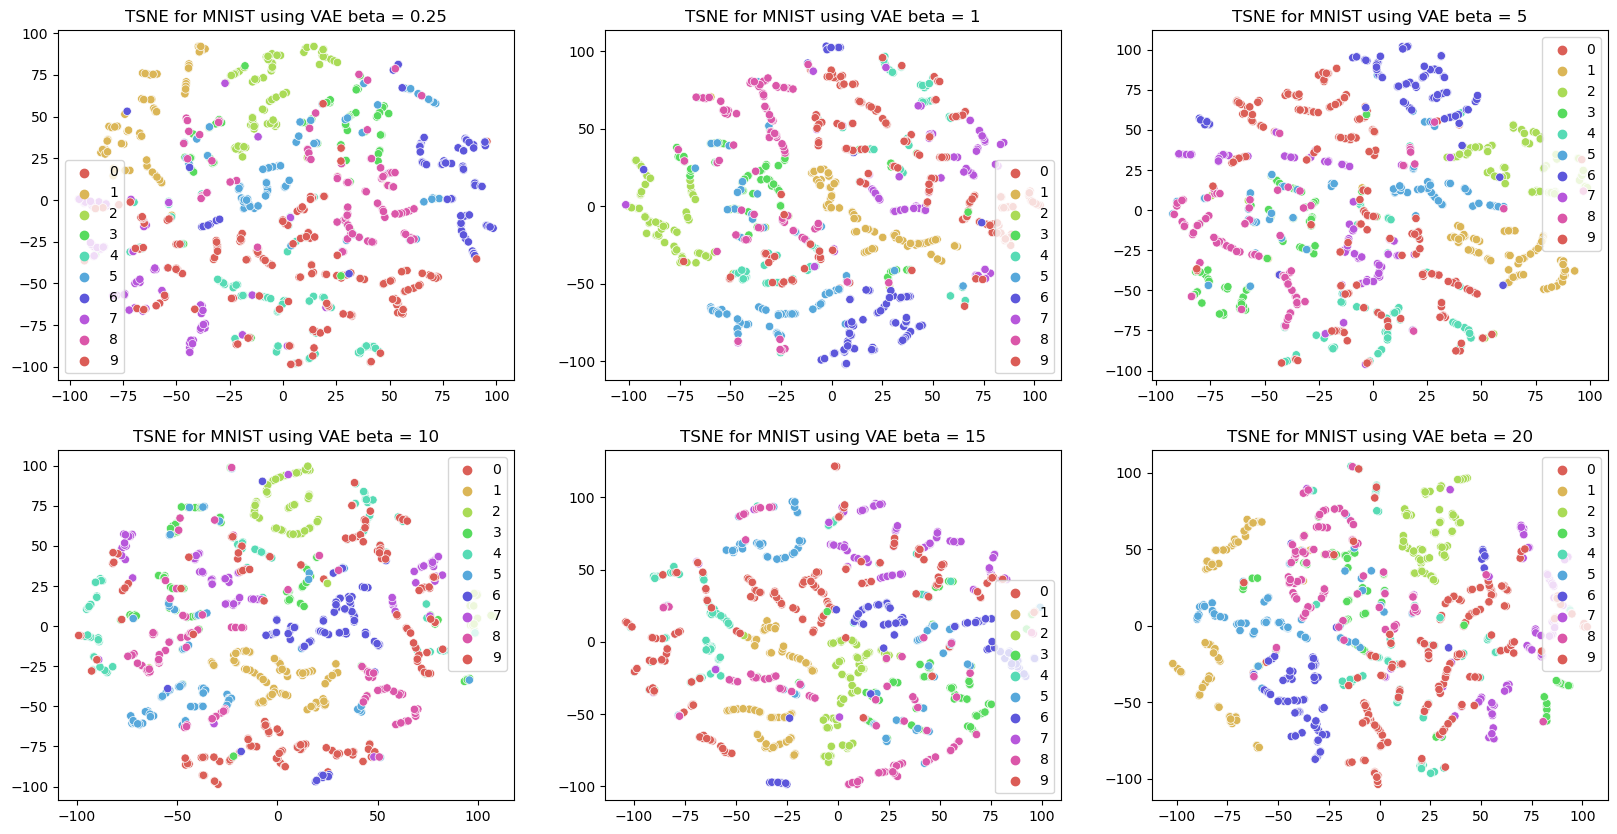

In [15]:
f, axes = plt.subplots(2, 3, figsize=(20,10))
axes = axes.flatten()
a=0
for z_beta_i,label_beta,b_i in zip(z_embedeed_vf_1000_beta, label_mnist_1000_beta, betas):
    axis = sns.scatterplot(x= z_beta_i[:,0],y= z_beta_i[:,1], hue = label_beta, legend = "full", palette="hls", ax=axes[a])
    axis.set_title("TSNE for MNIST using VAE beta = {}".format(b_i))
    a += 1

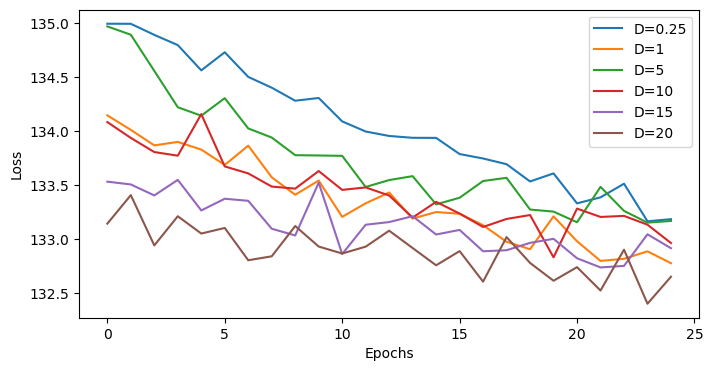

In [21]:
def plot_loss_D(dim_values,loss_list):
    """
    Display loss evolution for multiple dimension values

    Args: 
        loss_list: List of tuples containing dimension value and corresponding loss values per epoch
    """

    # Create and display plot
    fig, axis = plt.subplots(1, 1, figsize=(8, 4))

    for dim, loss in zip(dim_values,loss_list):
        axis.plot(loss, label=f'D={dim}')

    axis.set_xlabel("Epochs")
    axis.set_ylabel("Loss")
    axis.legend()
    plt.show()


plot_loss_D(betas, loss_mnist_v_list_plot_mnist)

## **2.2. Variational Auto-Encoder with Convolutional Network**

In [17]:
class VAE_Conv(nn.Module):
    
    def __init__(self, convFeatures=(32, 64), hidden_dim=50, latent_dim=2, channelsin=1,
                 img_width=28, img_height=28, relu_factor = 0.2, device=device ):
        
        super(VAE_Conv, self).__init__()

        self.convFeatures = convFeatures
        self.relu_factor = relu_factor
        self.img_height = img_height
        self.img_width = img_width
        
        # ENCODER
        self.encodeConv1 = nn.Conv2d(in_channels=channelsin, 
                                     out_channels=self.convFeatures[0], 
                                     kernel_size=3,
                                     padding=1)
        self.encodeMaxPool = nn.MaxPool2d(kernel_size=2, 
                                           return_indices=True)
        self.encodeConv2 = nn.Conv2d(in_channels=self.convFeatures[0], 
                                     out_channels=self.convFeatures[1], 
                                     kernel_size=3,
                                     padding=1)
        self.totalPooledSize = self.convFeatures[1] * (self.img_width // 4) * (self.img_height // 4)

        # Mean and Variance
        self.encodeFC = nn.Linear(in_features=self.totalPooledSize, 
                                  out_features=hidden_dim)
        self.encodeMeanFC = nn.Linear(in_features=hidden_dim, 
                                      out_features=latent_dim)
        self.encodeVarianceFC = nn.Linear(in_features=hidden_dim, 
                                          out_features=latent_dim)

        # DECODER
        self.decodeFC1 = nn.Linear(in_features=latent_dim, 
                                   out_features=hidden_dim)
        self.decodeFC2 = nn.Linear(in_features=hidden_dim, 
                                   out_features=self.totalPooledSize)
        self.decodeUnPool1 = nn.MaxUnpool2d(kernel_size=2)
        self.decodeUnConv1 = nn.ConvTranspose2d(in_channels=self.convFeatures[1], 
                                                out_channels=self.convFeatures[0], 
                                                kernel_size=3,
                                                padding=1)
        self.decodeUnPool2 = nn.MaxUnpool2d(kernel_size=2)
        self.decodeUnConv2 = nn.ConvTranspose2d(in_channels=self.convFeatures[0], 
                                                out_channels=1, 
                                                kernel_size=3,
                                                padding=1)
        self.decodeFinalConv = nn.Conv2d(in_channels=1, 
                                         out_channels=channelsin, 
                                         kernel_size=3,
                                         padding=1)
        self.normalDist = torch.distributions.Normal(torch.zeros(latent_dim), torch.ones(latent_dim))

     
    def encode(self, x):
        x = nn.LeakyReLU(self.relu_factor, inplace=True)(self.encodeConv1(x))
        x, self.indices1 = self.encodeMaxPool(x)
        x = nn.LeakyReLU(self.relu_factor, inplace=True)(self.encodeConv2(x))
        x, self.indices2 = self.encodeMaxPool(x)
        x = x.view(-1, self.totalPooledSize)
        x = nn.LeakyReLU(self.relu_factor, inplace=True)(self.encodeFC(x))
        mean = nn.Flatten()(self.encodeMeanFC(x))
        varianceLog = self.encodeVarianceFC(x)
        return mean, varianceLog

    def reparameterization_gaussian(self, mean, var):
        epsilon = torch.randn_like(var).to(device)  
        z = mean + var * epsilon
        return z

    def decode(self, x):
        x = nn.LeakyReLU(self.relu_factor, inplace=True)(self.decodeFC1(x))
        x = nn.LeakyReLU(self.relu_factor, inplace=True)(self.decodeFC2(x))
        x = x.view(-1, self.convFeatures[1], self.img_height // 4, self.img_width // 4)
        x = self.decodeUnPool1(x, indices=self.indices2)
        x = nn.LeakyReLU(self.relu_factor, inplace=True)(self.decodeUnConv1(x))
        x = self.decodeUnPool2(x, indices=self.indices1)
        x = nn.LeakyReLU(self.relu_factor, inplace=True)(self.decodeUnConv2(x))
        x = nn.LeakyReLU(self.relu_factor, inplace=True)(self.decodeFinalConv(x))
        return torch.sigmoid(x)

    def forward(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterization_gaussian(mean, logvar)
        x_hat = self.decode(z)
        return x_hat, mean, logvar

### **2.2.1 MNIST with Z=2**

**Compile model**

In [18]:
######## INITIAL PARAMETERS LOADING

# Get image size
for img, lbl in MNIST_traindataset:
    break

# IMAGE PARAMETERS
IMG_HEI = img[0].squeeze().shape[0]
IMG_WID = img[0].squeeze().shape[1]
CHL_INP = 1

# AUTO-ENCODER PARAMETERS
HID_DIM = 40
LAT_DIM = 2
RELU_T = 0.2
CONV_FEAT = [32,64]

# TRAINING PARAMETERS
model_cmnist = VAE_Conv(convFeatures=CONV_FEAT, hidden_dim=HID_DIM, latent_dim = LAT_DIM,
                        channelsin=CHL_INP, img_width=IMG_WID, img_height=IMG_HEI,
                        relu_factor=RELU_T, device=device).to(device)
optimizer = torch.optim.Adam(model_cmnist.parameters(), lr=1e-3)
epochs = 5

**Model training**

In [102]:
# Run model for MNIST dataset using CONV
loss_mnist_c, model_mnist_c = train_model(model_cmnist, MNIST_traindataset, epochs,
                                           batch_size, optimizer, device,
                                           model_type= "square", verbose = 1)

Starting model training...


938it [00:51, 18.15it/s]


	Epoch 1 	Average Loss:  51.306999432493555


938it [00:52, 17.96it/s]


	Epoch 2 	Average Loss:  50.96982209277891


938it [00:52, 17.76it/s]


	Epoch 3 	Average Loss:  50.749884166737885


938it [00:53, 17.56it/s]


	Epoch 4 	Average Loss:  50.62225719806097


938it [00:54, 17.27it/s]

	Epoch 5 	Average Loss:  50.55529991972281
Model training successfully


'Loss plotted successfully'

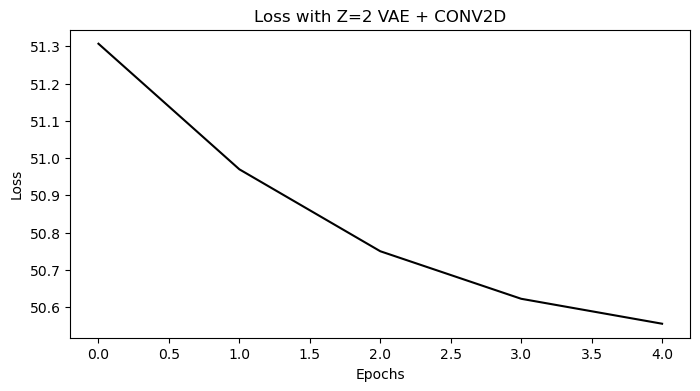

In [103]:
# Plot loss function
plot_loss(loss_mnist_c, "Loss with Z=2 VAE + CONV2D")

'Loss plotted successfully'

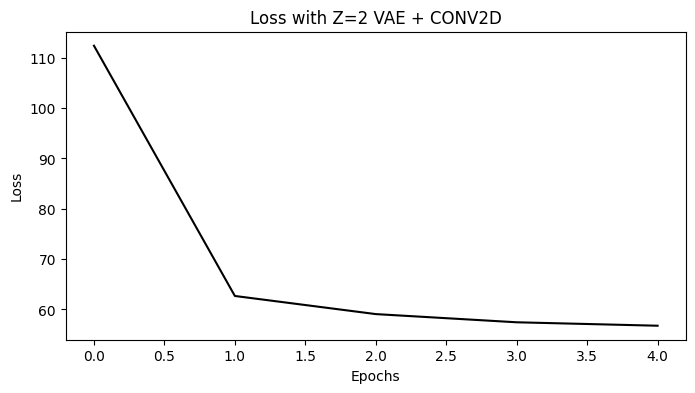

In [123]:
# Plot loss function
plot_loss(loss_mnist_c, "Loss with Z=2 VAE + CONV2D")

**Samples generation**

In [26]:
# Draw samples from the MNIST dataset
samples_mnist_1, _ = mnist_extractor(1, MNIST_testdataset_raw, "Audio")

# Generate images using the VAE + Convolutional layers
decoded_mnist_c_1, z_mnist_c_1  = samples_generator_VAECONV2D(samples_mnist_1, model_mnist_c, device, LAT_DIM, 1, 2 )

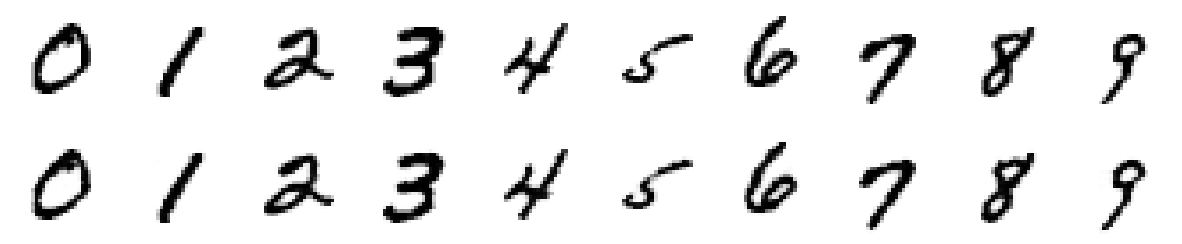

In [29]:
# Show comparison

fig, axis = plt.subplots(2,10, figsize= (15,3))
for i in range(len(samples_mnist_1)):
    axis[0][i].imshow(samples_mnist_1[i].view(28,28), cmap = "gray_r")
    axis[1][i].imshow(decoded_mnist_c_1[i].view(28,28).to("cpu").detach().numpy(), cmap ="gray_r")
    axis[0][i].axis("off")
    axis[1][i].axis("off")

**Distribution map**

In [94]:
# Take 100 samples for each label in the mnist dataset and perform VAE
samples_mnist_100, label_mnist_100 = mnist_extractor(100, MNIST_testdataset_raw, "square")
decoded_mnist_c_100, z_mnist_c_100 = samples_generator_VAECONV2D(samples_mnist_100, model_mnist_c, device, LAT_DIM, 1,2 )

(Text(0.5, 0, 'Z1'),
 Text(0, 0.5, 'Z2'),
 Text(0.5, 1.0, 'Distribution MNIST for Z=2 using Conv2D'))

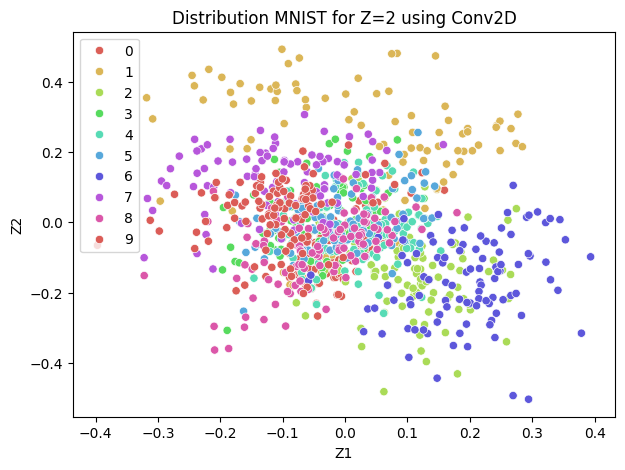

In [107]:
# Create plot
fig, axis = plt.subplots(1,1, figsize =(7,5))

# Show label distribution
axis = sns.scatterplot(x= z_mnist_c_100[:,0],y= z_mnist_c_100[:,1], hue = label_mnist_100, legend = "full", palette="hls")
axis.set_xlabel("Z1"), axis.set_ylabel("Z2"), axis.set_title("Distribution MNIST for Z=2 using Conv2D")

**Manifold**

In [90]:
def plot_random_Z(samples, model, device, LAT_DIM):

    # Create list for saving encoding
    encoding = []
    decoding = []
    reparametrization_val = np.zeros((len(samples), LAT_DIM))

    fig, axis = plt.subplots(1, 30, figsize = (7,7))
    axis = axis.flatten()


    array = np.arange(-0.5,0.5, 0.034)
    z_val = []

    for i in range(len(array)):
        for j in range(len(array)):
            z_val.append(torch.tensor([[array[i],array[j]]], dtype = torch.float32).to(device))

    
    for i in range(len(samples)):
        for j in range(30):#*30):
            ## ENCODE
            # Avoid gradient computation 
            with torch.no_grad():

                # Compute mu and sigma values
                a,b,c = samples[i].shape
                mu, sigma = model.encode(scale_data(samples[i]).view(1,a,b,c))
                encoding.append((mu, sigma))

            ## DECODE
            # Generate epsilon values
            eps = torch.randn_like(sigma)
            # Perform reparametrization trick
            z = mu + sigma*eps
            reparametrization_val[i] = z.to("cpu").detach().numpy()
            
            # Perform reparametrization trick
            # Create random Z variables for recreate images using VAE



            # Obtain new image, reshape it, send it back to cpu and convert it back into numpy array
            #for j in range(30*30):
            xx = model.decode(z_val[j]).reshape(28,28).to(device).detach().numpy()
            #decoding.append(xx)
            axis[j].imshow(xx, cmap="gray_r"), axis[j].axis("off")
            
        # plot results
       
    # reconstruction
    #for i in range(30*30):
    #    axis[i].imshow(decoding[i], cmap="gray_r"), axis[i].axis("off")

    #return plt.show()

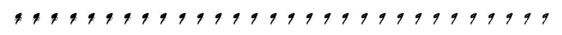

In [106]:
plot_random_Z(samples_mnist_100, model_mnist_c, device, LAT_DIM )

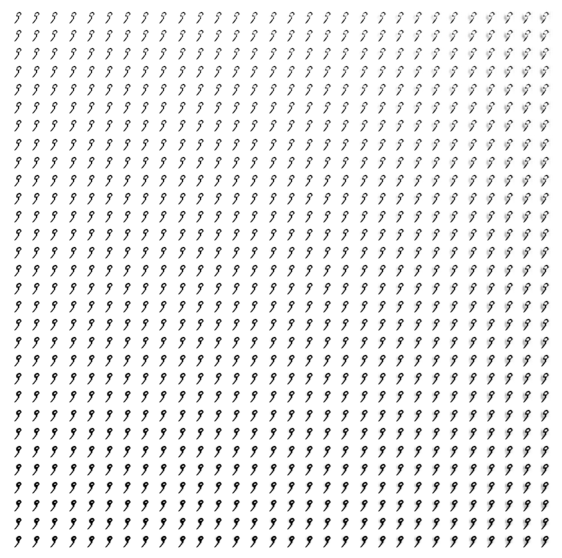

In [130]:
# Create random Z variables for recreate images using VAE
array = np.arange(-0.5,0.5, 0.034)
z_val = []
for i in range(len(array)):
    for j in range(len(array)):
        z_val.append(torch.tensor([[array[i],array[j]]], dtype = torch.float32).to(device))

fig, axis = plt.subplots(30, 30, figsize = (7,7))
axis = axis.flatten()

for i in range(30*30):
    axis[i].imshow(model_mnist_c.decode(z_val[i]).reshape(28,28).to("cpu").detach().numpy(), cmap="gray_r"), axis[i].axis("off")

### **2.2.2 MNIST with Z=20**

**Compile model**

In [10]:
######## INITIAL PARAMETERS LOADING

# Get image size
for img, lbl in MNIST_traindataset:
    break

# IMAGE PARAMETERS
IMG_HEI = img[0].squeeze().shape[0]
IMG_WID = img[0].squeeze().shape[1]
CHL_INP = 1

# AUTO-ENCODER PARAMETERS
HID_DIM = 4000
LAT_DIM = 20
RELU_T = 0.2
CONV_FEAT = [32,64]

# TRAINING PARAMETERS
model_cmnist_f = VAE_Conv(convFeatures=CONV_FEAT, hidden_dim=HID_DIM, latent_dim = LAT_DIM,
                        channelsin=CHL_INP, img_width=IMG_WID, img_height=IMG_HEI,
                        relu_factor=RELU_T, device=device).to(device)
optimizer = torch.optim.Adam(model_cmnist_f.parameters(), lr=1e-3)
epochs = 25

**Model training**

In [11]:
# Run model for MNIST dataset using CONV and full latent dimension (>2)
loss_mnist_cf, model_mnist_cf = train_model(model_cmnist_f, MNIST_traindataset, epochs,
                                           batch_size, optimizer, device,
                                           model_type= "square", verbose = 0)

Starting model training...


938it [00:18, 50.19it/s]
938it [00:18, 51.08it/s]
938it [00:18, 50.94it/s]
938it [00:18, 50.87it/s]
938it [00:18, 50.81it/s]
938it [00:18, 50.68it/s]
938it [00:19, 48.70it/s]
938it [00:18, 50.68it/s]
938it [00:18, 50.71it/s]
938it [00:18, 50.72it/s]
938it [00:18, 50.73it/s]
938it [00:18, 50.70it/s]
938it [00:18, 50.71it/s]
938it [00:18, 50.68it/s]
938it [00:21, 43.40it/s]
938it [00:19, 48.64it/s]
938it [00:18, 50.68it/s]
938it [00:18, 50.68it/s]
938it [00:18, 50.66it/s]
938it [00:19, 48.62it/s]
938it [00:19, 48.64it/s]
938it [00:19, 48.59it/s]
938it [00:19, 48.56it/s]
938it [00:18, 50.63it/s]
938it [00:18, 50.67it/s]

Model training successfully


'Loss plotted successfully'

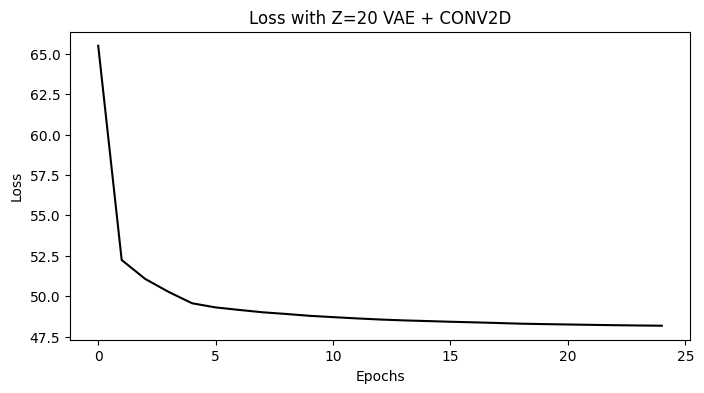

In [12]:
# Show loss evolution
plot_loss(loss_mnist_cf, "Loss with Z={} VAE + CONV2D".format(LAT_DIM))

**Samples Generation**

In [13]:
# Draw samples from the MNIST dataset
samples_mnist_1, _ = mnist_extractor(1, MNIST_testdataset_raw, "Audio")

# Generate images using the VAE + Convolutional layers
decoded_mnist_cf_1, z_mnist_cf_1  = samples_generator_VAECONV2D(samples_mnist_1, model_mnist_cf, device, LAT_DIM )

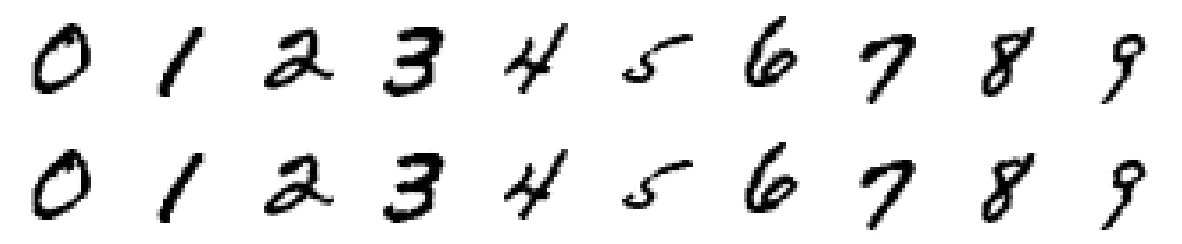

In [14]:
# Show comparison

fig, axis = plt.subplots(2,10, figsize= (15,3))
for i in range(len(samples_mnist_1)):
    axis[0][i].imshow(samples_mnist_1[i].view(28,28), cmap = "gray_r")
    axis[1][i].imshow(decoded_mnist_cf_1[i], cmap ="gray_r")
    axis[0][i].axis("off")
    axis[1][i].axis("off")

**Distribution map**

In [31]:
# Take 100 samples for each label in the mnist dataset and perform VAE
samples_mnist_100, label_mnist_1000 = mnist_extractor(100, MNIST_testdataset_raw, "square")
decoded_mnist_cf_1000, z_mnist_cf_1000 = samples_generator_VAECONV2D(samples_mnist_100, model_mnist_cf, device, LAT_DIM )

# Apply TSNE for show distribution map
z_embedeed_cf_1000 = TSNE(n_components=2, learning_rate='auto', init='random',method ="exact", perplexity=3).fit_transform(z_mnist_cf_1000)

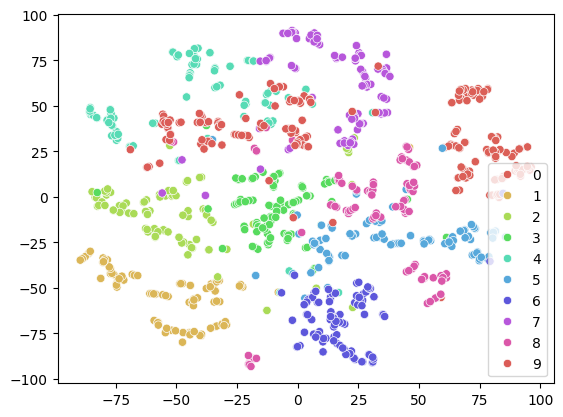

In [32]:
axis = sns.scatterplot(x= z_embedeed_cf_1000[:,0],y= z_embedeed_cf_1000[:,1], hue = label_mnist_1000, legend = "full", palette="hls")

# **3. VAE + CONV2D in Audio spectograms**

### **3.1. Data Loading**

This dataset is made of 8 words in .wav:  `no`, `yes`, `down`, `go`, `left`, `up`, `right`, and `stop`.

In [7]:
# Set folder directory
DATASET_PATH = 'data/mini_speech_commands'

# Download data
data_dir = pathlib.Path(DATASET_PATH)
if not data_dir.exists():
  tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir='data')

In [8]:
# Create training and validation set
train_data, val_data = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=16000,
    subset='both')

Found 8000 files belonging to 8 classes.
Using 6400 files for training.
Using 1600 files for validation.


2024-03-26 23:29:00.185176: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-26 23:29:00.196772: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-26 23:29:00.200810: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [9]:
labels = ["down","go", "left", "no", "right", "stop", "up", "yes"]

### **3.2. Feature extraction**

In [10]:
def squeeze_audio(audio, labels):
  """
  Squeeze axis for easy using
  """
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

# Squeeze non-necesary axis
train_data = train_data.map(squeeze_audio, tf.data.AUTOTUNE)

In [11]:
def get_spectrogram_torch(waveform):
    """
    Given a waveform, convert it into a spectogram

    Args:
        waveform -> wave file
        n_ftt -> number of filters
        hop_length ->

    Return:
        Audio spectogram
    """
    # Convert to torch
    waveform = torch.from_numpy(waveform.numpy())

    # Convert the waveform to a spectrogram
    spectrogram_ = torchaudio.transforms.Spectrogram(n_fft=256, hop_length=130)

    # Perform transform
    spectrogram = spectrogram_(waveform)

    return spectrogram

In [12]:
# Assuming train_spectrogram_ds contains spectrogram tensors and labels
# You need to convert them into torch tensors and then create a TensorDataset

def preprocessing(training_data):
    """
    Convert .wav files into spectograms ready for being used in a convolutional neural network

    Args:
        training_data -> tensor with waveforms and labels

    Return:
        spectogram_data -> spectograms
        label_data -> labels 
    """

    spectrogram_tensors = []
    label_tensors = []

    for waveform, label in training_data:
        spec_tensor = get_spectrogram_torch(waveform)
        label_tensor = torch.from_numpy(label.numpy())
        spectrogram_tensors.append(spec_tensor)
        label_tensors.append(label_tensor)

    # Stack the tensors along the first dimension
    spectrogram_data = torch.stack(spectrogram_tensors).view(-1,1,129,124)
    label_data = torch.stack(label_tensors).view(-1)

    
    return TensorDataset(spectrogram_data, label_data)

# Apply preprocessing
spec_data = preprocessing(train_data)


### **3.3. Training model with Z=2**

**Model compile**

In [14]:
######## INITIAL PARAMETERS LOADING

# SPECTROGRAM PARAMETERS
IMG_HEIGHT = 129
IMG_WIDTH = 124
CHL_INP = 1

# AUTO-ENCODER PARAMETERS
HID_DIM = 10
LAT_DIM = 2
RELU_T = 0.2
CONV_FEAT = [32,64]

# TRAINING PARAMETERS
model_cspec = VAE_Conv(convFeatures=CONV_FEAT, hidden_dim=HID_DIM, latent_dim = LAT_DIM,
                        channelsin=CHL_INP, img_width=IMG_WIDTH, img_height=IMG_HEIGHT,
                        relu_factor=RELU_T, device=device).to(device)
optimizer = torch.optim.Adam(model_cspec.parameters(), lr=1e-3)
epochs = 10
batch_size = 64

**Model training**

In [15]:
# Run model for Audio spectogram dataset using CONV2D
loss_spectrogram_c, model_spectrogram_c = train_model(model_cspec, spec_data, epochs,
                                           batch_size, optimizer, device,
                                           model_type= "Audio", verbose = 1, size = (IMG_HEIGHT, IMG_WIDTH))

Starting model training...


6400it [00:21, 293.74it/s]


	Epoch 1 	Average Loss:  1173.4299407319309


6400it [00:21, 295.79it/s]


	Epoch 2 	Average Loss:  10.204643518296159


6400it [00:21, 293.62it/s]


	Epoch 3 	Average Loss:  67.53278097910403


6400it [00:20, 316.01it/s]


	Epoch 4 	Average Loss:  5.061298483059655


6400it [00:21, 299.21it/s]


	Epoch 5 	Average Loss:  3.0839483727792554


6400it [00:21, 291.72it/s]


	Epoch 6 	Average Loss:  2.4710409920473437


6400it [00:21, 292.82it/s]


	Epoch 7 	Average Loss:  2.3282980850933677


6400it [00:21, 294.75it/s]


	Epoch 8 	Average Loss:  2.1889886407647063


6400it [00:21, 292.95it/s]


	Epoch 9 	Average Loss:  2.142609037522935


6400it [00:21, 291.36it/s]

	Epoch 10 	Average Loss:  2.1162028127553816
Model training successfully


'Loss plotted successfully'

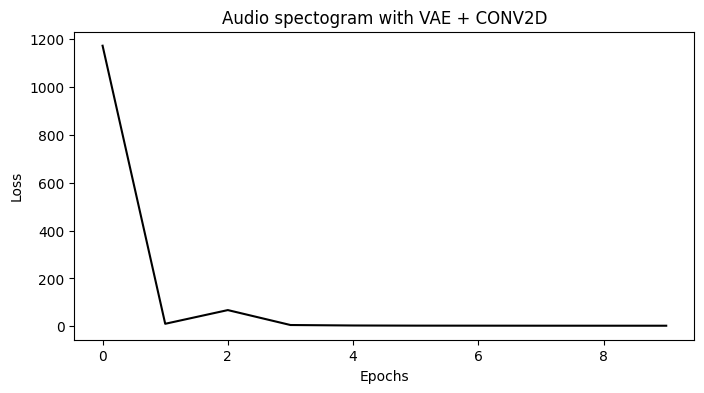

In [16]:
# Plot loss
plot_loss(loss_spectrogram_c, "Audio spectogram with VAE + CONV2D")

**Samples generation**

In [26]:
def plot_spectograms(samples, model, labels,lat_dim, plot = True):
    # Create list for saving encoding
    encoding = []
    decoding = []
    reparametrization_val = np.zeros((len(samples), lat_dim))
    if plot == True:
        fig, axis = plt.subplots(2,8, figsize= (15,3))
    for i in range(len(samples)):
        
        ## ENCODE
        # Avoid gradient computation 
        with torch.no_grad():

            # Compute mu and sigma values
            a,b,c = samples[i].shape
            mu, sigma = model.encode(scale_data(samples[i]).view(1,a,b,c))
            encoding.append((mu, sigma))

        ## DECODE
        # Generate epsilon values
        eps = torch.randn_like(sigma)
        # Perform reparametrization trick
        z = mu + sigma*eps
        reparametrization_val[i] = z
        # Obtain new image, reshape it, send it back to cpu and convert it back into numpy array
        decoding.append(scale_data(model.decode(z), size=(129,124), resize=True).reshape(129,124).to("cpu"))#.detach().numpy())

        # plot results
        # original
        xx = samples[i].view(129,124).numpy()
        log_spec = np.log(xx + np.finfo(float).eps)
        height = log_spec.shape[0]
        width = log_spec.shape[1]
        X = np.linspace(0, np.size(xx), num=width, dtype=int)
        Y = range(height)
        if plot == True:
            axis[0][i].pcolormesh(X, Y, log_spec)
            axis[0][i].set_title(labels[i])
        #axis[0][i].imshow(samples[i].view(129,124) )
        
        # reconstruction
        #print(decoding[i].shape)
        #xx = decoding[i]#.view(124,129)
        xx = scale_data(model.decode(z), size=(129,124), resize=True).reshape(129,124).to("cpu").detach().numpy()
        log_spec = np.log(xx + np.finfo(float).eps)
        height = log_spec.shape[0]
        width = log_spec.shape[1]
        X = np.linspace(0, np.size(xx), num=width, dtype=int)
        Y = range(height)
        if plot == True:
            axis[1][i].pcolormesh(X, Y, log_spec)   
            axis[0][i].axis("off")
            axis[1][i].axis("off")

    return decoding, reparametrization_val


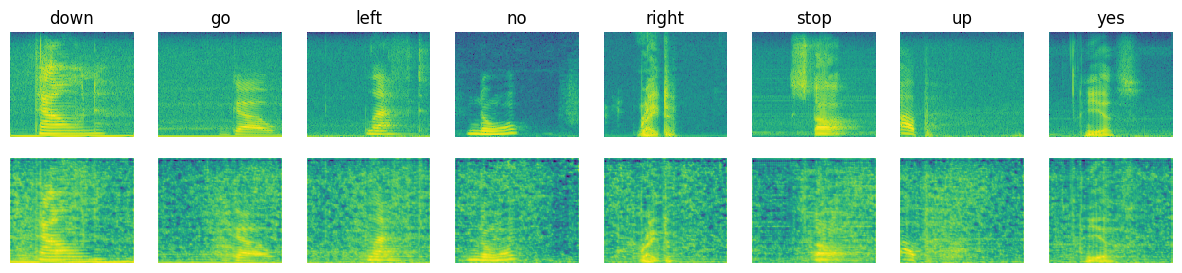

In [27]:
# Extract samples from audio set
samples_spec_1, label_spec_1 = audios_extractor(spec_data, 1, 8)
# Plot spectograms
decoded_spec_1, z_spec_1 = plot_spectograms(samples_spec_1, model_spectrogram_c.cpu(), labels, LAT_DIM, True )

**Audio listening**

In [20]:
def audio_listening(original, generated, labels):
    """
    Convert spectograms back to .wav files and play them

    Args:
        original -> original spectrogram samples
        generated -> generated spectrogram
    """

    for idx, spl in enumerate(original):
        # Play original sample
        print("Sample label: {} \n".format(labels[idx]))
        print("Original sample: \n")
        reconstruc_spec = spectrogram_to_waveform_torch(original[idx])
        display.display(display.Audio(reconstruc_spec.detach().numpy(), rate=129*124))
        print("Genereated sample: \n")
        reconstruc_spec = spectrogram_to_waveform_torch(generated[idx])
        display.display(display.Audio(reconstruc_spec.detach().numpy(), rate=129*124))
        print("--------------------")

In [21]:
audio_listening(samples_spec_1, decoded_spec_1, labels)

Sample label: down 

Original sample: 



Genereated sample: 



--------------------
Sample label: go 

Original sample: 



Genereated sample: 



--------------------
Sample label: left 

Original sample: 



Genereated sample: 



--------------------
Sample label: no 

Original sample: 



Genereated sample: 



--------------------
Sample label: right 

Original sample: 



Genereated sample: 



--------------------
Sample label: stop 

Original sample: 



Genereated sample: 



--------------------
Sample label: up 

Original sample: 



Genereated sample: 



--------------------
Sample label: yes 

Original sample: 



Genereated sample: 



--------------------


**Distribution map**

In [30]:
# Extract samples from audio set
samples_spec_100, label_spec_100 = audios_extractor(spec_data, 100, 8)
# Plot spectograms
decoded_spec_100, z_spec_100 = plot_spectograms(samples_spec_100, model_spectrogram_c.cpu(), labels,LAT_DIM, False )

(Text(0.5, 0, 'Z1'),
 Text(0, 0.5, 'Z2'),
 Text(0.5, 1.0, 'Distribution Spectogram for Z=2 using Conv2D'))

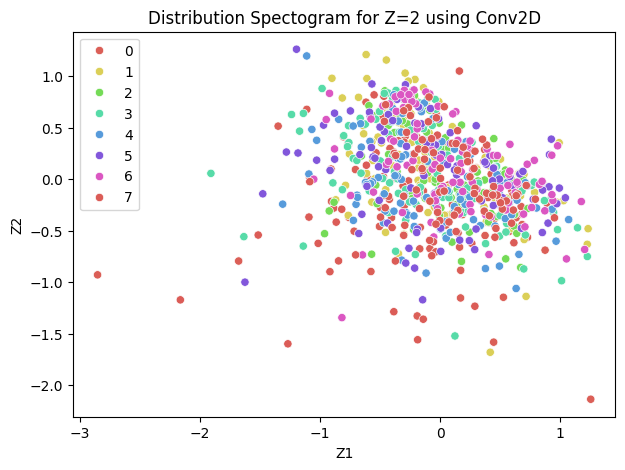

In [31]:
# Create plot
fig, axis = plt.subplots(1,1, figsize =(7,5))

# Show label distribution
axis = sns.scatterplot(x= z_spec_100[:,0],y= z_spec_100[:,1], hue = label_spec_100, legend = "full", palette="hls")
axis.set_xlabel("Z1"), axis.set_ylabel("Z2"), axis.set_title("Distribution Spectogram for Z=2 using Conv2D")

### **3.4. Training model with Z=20**

**Model compile**

In [34]:
######## INITIAL PARAMETERS LOADING

# SPECTROGRAM PARAMETERS
IMG_HEIGHT = 129
IMG_WIDTH = 124
CHL_INP = 1

# AUTO-ENCODER PARAMETERS
HID_DIM = 40
LAT_DIM = 20
RELU_T = 0.2
CONV_FEAT = [32,64]

# TRAINING PARAMETERS
model_cspec = VAE_Conv(convFeatures=CONV_FEAT, hidden_dim=HID_DIM, latent_dim = LAT_DIM,
                        channelsin=CHL_INP, img_width=IMG_WIDTH, img_height=IMG_HEIGHT,
                        relu_factor=RELU_T, device=device).to(device)
optimizer = torch.optim.Adam(model_cspec.parameters(), lr=1e-3)
epochs = 30
batch_size = 64

**Model training**

In [35]:
# Run model for Audio spectogram dataset using CONV2D
loss_spectrogram_cf, model_spectrogram_cf = train_model(model_cspec, spec_data, epochs,
                                           batch_size, optimizer, device,
                                           model_type= "Audio", verbose = 1, size = (IMG_HEIGHT, IMG_WIDTH))

Starting model training...


6400it [00:32, 200.00it/s]


	Epoch 1 	Average Loss:  3.9030067071302326


6400it [00:32, 199.16it/s]


	Epoch 2 	Average Loss:  2.1341960506828377


6400it [00:32, 197.91it/s]


	Epoch 3 	Average Loss:  2.0615529016342586


6400it [00:32, 198.88it/s]


	Epoch 4 	Average Loss:  2.033578893149676


6400it [00:30, 210.75it/s]


	Epoch 5 	Average Loss:  2.065841207920266


6400it [00:32, 198.68it/s]


	Epoch 6 	Average Loss:  2.0428069789165777


6400it [00:32, 198.35it/s]


	Epoch 7 	Average Loss:  2.025196358871229


6400it [00:32, 199.39it/s]


	Epoch 8 	Average Loss:  2.0212537130749326


6400it [00:32, 198.36it/s]


	Epoch 9 	Average Loss:  2.0112692840626734


6400it [00:30, 208.43it/s]


	Epoch 10 	Average Loss:  2.006595930893508


6400it [00:31, 201.63it/s]


	Epoch 11 	Average Loss:  2.015603158011122


6400it [00:28, 221.33it/s]


	Epoch 12 	Average Loss:  2.0033363717517774


6400it [00:30, 213.32it/s]


	Epoch 13 	Average Loss:  1.99936388877057


6400it [00:32, 196.04it/s]


	Epoch 14 	Average Loss:  1.9916803128650586


6400it [00:31, 205.73it/s]


	Epoch 15 	Average Loss:  1.9952530698848714


6400it [00:31, 200.05it/s]


	Epoch 16 	Average Loss:  1.9921283106549417


6400it [00:33, 190.52it/s]


	Epoch 17 	Average Loss:  1.9981809242579467


6400it [00:33, 192.21it/s]


	Epoch 18 	Average Loss:  1.9853787583580313


6400it [00:33, 191.49it/s]


	Epoch 19 	Average Loss:  1.9943714725713206


6400it [00:32, 196.08it/s]


	Epoch 20 	Average Loss:  1.9831233455331312


6400it [00:32, 196.20it/s]


	Epoch 21 	Average Loss:  1.9831953205332418


6400it [00:33, 191.68it/s]


	Epoch 22 	Average Loss:  1.979210732443889


6400it [00:33, 190.99it/s]


	Epoch 23 	Average Loss:  1.9812139218385227


6400it [00:31, 200.43it/s]


	Epoch 24 	Average Loss:  1.9804537178208295


6400it [00:32, 194.97it/s]


	Epoch 25 	Average Loss:  1.9737057755479293


6400it [00:32, 196.64it/s]


	Epoch 26 	Average Loss:  1.9816843702012923


6400it [00:31, 200.69it/s]


	Epoch 27 	Average Loss:  1.9750479931970335


6400it [00:31, 203.00it/s]


	Epoch 28 	Average Loss:  1.978328460011562


6400it [00:32, 196.34it/s]


	Epoch 29 	Average Loss:  1.9867588514265633


6400it [00:32, 196.23it/s]

	Epoch 30 	Average Loss:  1.9684691760018946
Model training successfully


**Samples generation**

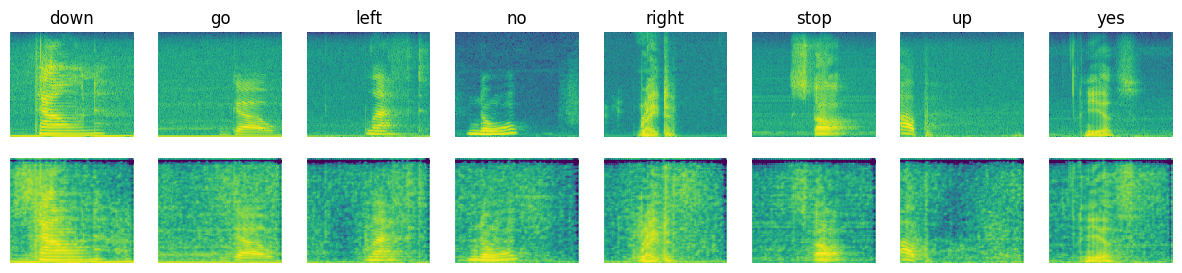

In [37]:
# Extract samples from audio set
samples_specf_1, label_spec_1 = audios_extractor(spec_data, 1, 8)
# Plot spectograms
decoded_specf_1, z_specf_1 = plot_spectograms(samples_specf_1, model_spectrogram_cf.cpu(), labels, LAT_DIM, True )

**Audio Listening**

In [38]:
# Display sound
audio_listening(samples_specf_1, decoded_specf_1, labels)

Sample label: down 

Original sample: 



Genereated sample: 



--------------------
Sample label: go 

Original sample: 



Genereated sample: 



--------------------
Sample label: left 

Original sample: 



Genereated sample: 



--------------------
Sample label: no 

Original sample: 



Genereated sample: 



--------------------
Sample label: right 

Original sample: 



Genereated sample: 



--------------------
Sample label: stop 

Original sample: 



Genereated sample: 



--------------------
Sample label: up 

Original sample: 



Genereated sample: 



--------------------
Sample label: yes 

Original sample: 



Genereated sample: 



--------------------


**Distribution map**

In [39]:
# Extract samples from audio set
samples_specf_100, label_specf_100 = audios_extractor(spec_data, 100, 8)
# Plot spectograms
decoded_specf_100, z_specf_100 = plot_spectograms(samples_specf_100, model_spectrogram_cf.cpu(), labels,LAT_DIM, False )

# Apply TSNE for show distribution map
z_embedeed_specf_1000 = TSNE(n_components=2, learning_rate='auto', init='random',method ="exact", perplexity=3).fit_transform(z_specf_100)

Text(0.5, 1.0, 'TSNE for Audio spectograms using VAE Z = 20')

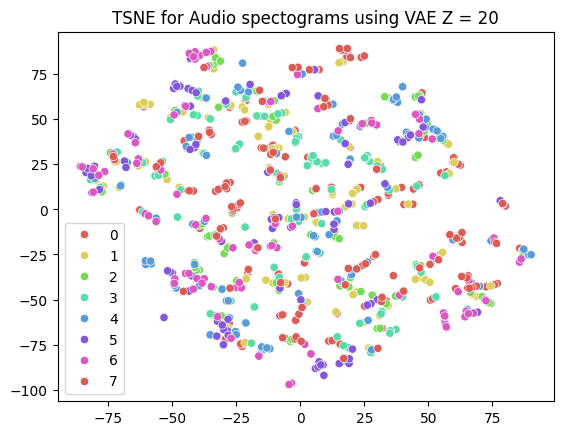

In [41]:
# Plot distribution
axis = sns.scatterplot(x= z_embedeed_specf_1000[:,0],y= z_embedeed_specf_1000[:,1], hue = label_specf_100, legend = "full", palette="hls")
axis.set_title("TSNE for Audio spectograms using VAE Z = {}".format(LAT_DIM))

### **3.4. Comparison with different Z values**

In [25]:
######## INITIAL PARAMETERS LOADING

# SPECTROGRAM PARAMETERS
IMG_HEIGHT = 129
IMG_WIDTH = 124
CHL_INP = 1

# AUTO-ENCODER PARAMETERS
HID_DIM = 10
LAT_DIM = [2, 5, 10, 15, 20]
RELU_T = 0.2
CONV_FEAT = [32,64]

# TRAINING PARAMETERS
model_cspec_list = []
optimizer_list = []
for lat_dim in LAT_DIM:
    model_cspec = VAE_Conv(convFeatures=CONV_FEAT, hidden_dim=HID_DIM, latent_dim = lat_dim,
                            channelsin=CHL_INP, img_width=IMG_WIDTH, img_height=IMG_HEIGHT,
                            relu_factor=RELU_T, device=device).to(device)
    optimizer = torch.optim.Adam(model_cspec.parameters(), lr=1e-3)
    epochs = 10
    batch_size = 64

In [ ]:
# Run model for Audio spectogram dataset using CONV2D
loss_spectrogram_c_list = [] 
model_spectrogram_c_list = []
for mdl, optim in zip(model_cspec_list, optimizer_list):
    loss_spectrogram_c, model_spectrogram_c = train_model(mdl, spec_data, epochs,
                                            batch_size, optim, device,
                                            model_type= "Audio", verbose = 1, size = (IMG_HEIGHT, IMG_WIDTH))
    loss_spectrogram_c_list.append(loss_spectrogram_c)
    model_spectrogram_c_list.append(model_spectrogram_c)

**Model training**

In [25]:
# Run model for Audio spectogram dataset using CONV2D
loss_spectrogram_c, model_spectrogram_c = train_model(model_cspec, spec_data, epochs,
                                           batch_size, optimizer, device,
                                           model_type= "Audio", verbose = 1, size = (IMG_HEIGHT, IMG_WIDTH))

Starting model training...


6400it [05:48, 18.36it/s]


	Epoch 1 	Average Loss:  4.173361723605385


6400it [05:02, 21.13it/s]


	Epoch 2 	Average Loss:  2.4872966686027613


6400it [05:18, 20.11it/s]


	Epoch 3 	Average Loss:  2.8391097209373104


6400it [09:14, 11.54it/s]


	Epoch 4 	Average Loss:  3.0441320758160995


6400it [09:14, 11.54it/s]


	Epoch 5 	Average Loss:  2.487121248067329


6400it [09:15, 11.52it/s]


	Epoch 6 	Average Loss:  2.394117372634728


6400it [08:20, 12.77it/s]


	Epoch 7 	Average Loss:  2.3487633249921376


6400it [08:21, 12.75it/s]


	Epoch 8 	Average Loss:  2.1927412823599415


6400it [08:17, 12.86it/s]


	Epoch 9 	Average Loss:  2.2505991669404617


6400it [08:45, 12.17it/s]

	Epoch 10 	Average Loss:  2.261293347314254
Model training successfully


'Loss plotted successfully'

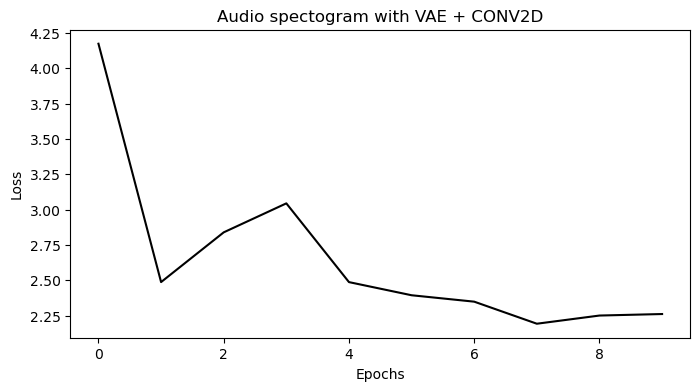

In [26]:
# HID_DIM = 10 - LAT_DIM = 2

plot_loss(loss_spectrogram_c, "Audio spectogram with VAE + CONV2D")

'Loss plotted successfully'

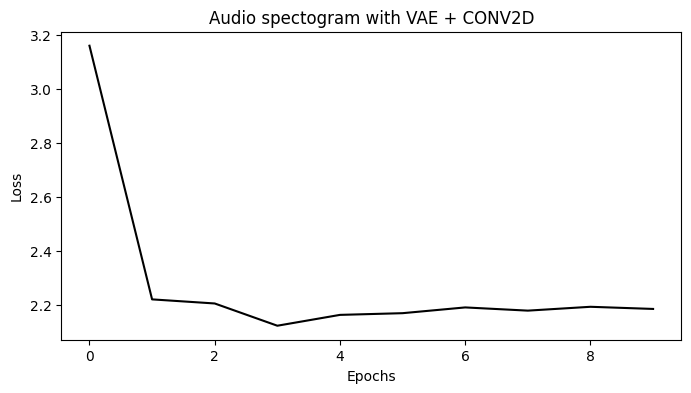

In [15]:
plot_loss(loss_spectrogram_c, "Audio spectogram with VAE + CONV2D")

**Samples generation**